The data flow of every exchange on Earth is as follows:

Agent  -  Order  -  OrderBook  -  Trade  -  Logger / Visualizer

MarketEnvironment (clock, orchestration) represents:
- The exchange
- The clock
- The event loop

Agents do not interact with each other. They only interact with the environment.

In [51]:
class Order:
    def __init__(self, order_id, side, price, qty, timestamp):
        self.id = order_id
        self.side = side        # 'buy' or 'sell'
        self.price = price
        self.qty = qty
        self.ts = timestamp

OrderBook
- Maintain bids / asks
- Enforce FIFO
- Match orders
- Emit trades

In [52]:
class OrderBook:
    def __init__(self):
        self.bids = []   # list of buy orders
        self.asks = []   # list of sell orders
        self.trades = []

    def add_order(self, order):
        if order.side == 'buy':
            self.bids.append(order)
            # sort: highest price first, then earlier time
            self.bids.sort(key=lambda o: (-o.price, o.ts))
        else:
            self.asks.append(order)
            # sort: lowest price first, then earlier time
            self.asks.sort(key=lambda o: (o.price, o.ts))

        self.match()

    def match(self):
        while self.bids and self.asks and self.bids[0].price >= self.asks[0].price:
            buy = self.bids[0]
            sell = self.asks[0]

            traded_qty = min(buy.qty, sell.qty)

            self.trades.append(
                (buy.id, sell.id, sell.price, traded_qty)
            )

            buy.qty -= traded_qty
            sell.qty -= traded_qty

            if buy.qty == 0:
                self.bids.pop(0)
            if sell.qty == 0:
                self.asks.pop(0)

    def print_top5(self):
        print("\nBUY SIDE")
        for o in self.bids[:5]:
            print(o.price, o.qty)

        print("SELL SIDE")
        for o in self.asks[:5]:
            print(o.price, o.qty)

    def best_bid(self):
        return self.bids[0].price if self.bids else None

    def best_ask(self):
        return self.asks[0].price if self.asks else None

    def mid_price(self):
        if self.best_bid() is None or self.best_ask() is None:
            return None
        return (self.best_bid() + self.best_ask()) / 2

In [53]:
# Minimal market interface
class MarketEnvironment:
    def __init__(self, book, agents, logger):
        self.book = book
        self.agents = agents
        self.t = 0
        self.trades = []
        self.logger = logger

    def step(self):
        self.t += 1
        for agent in self.agents:
            order = agent.act(self)
            if order:
                self.book.add_order(order)

        self.trades.extend(self.book.trades)
        self.book.trades = []

        self.logger.log(self)

Agent (who sends orders):
- decides what order to send
- never matches orders
- never touches the book directly

In [54]:
# Every trader is just a different act() logic.
class Agent:
    def act(self, env):
        raise NotImplementedError

Agent specializations

In [55]:
# RandomTrader - generate background liquidity and noise
import random
import numpy as np
class RandomTrader(Agent):
    def act(self, env):
        mid = env.book.mid_price()
        if mid is None:
            mid = 100
        side = random.choice(["buy", "sell"])
        price = int(np.random.normal(mid, 2))
        qty = random.randint(1, 5)
        return Order(env.t, side, price, qty, env.t)

In [56]:
# MarketTaker (aggressive) - consume liquidity and cause price impact
class MarketTaker(Agent):
    def act(self, env):
        if random.random() < 0.1:
            side = random.choice(["buy", "sell"])
            price = float('inf') if side == "buy" else 0
            return Order(env.t, side, price, 5, env.t)

In [57]:
# Simple Market Maker - tighten spread and stabilize price
class MarketMaker(Agent):
    def act(self, env):
        mid = env.book.mid_price()
        if mid is None:
            return None

        spread = 1
        qty = 5

        if random.random() < 0.5:
            return Order(env.t, "buy", int(mid - spread), qty, env.t)
        else:
            return Order(env.t, "sell", int(mid + spread), qty, env.t)

FIFO within price level
- higher price wins
- earlier order wins at same price

What is Pro-rata?

Pro-rata = proportional sharing

When a trade happens at a price level, everyone at that price gets filled in proportion to their size.

Why equities use FIFO?

FIFO rewards:
- early liquidity
- patience
- tighter spreads

Pro-rata rewards:
- size dominance
- whales

Equities want fairness.
Futures often use pro-rata.

Logger
Ensures:
- book
- agents
- plots

don’t mix responsibilities.

In [58]:
class Logger:
    def __init__(self):
        self.bb = []
        self.ba = []
        self.trades = []

    def log(self, env):
        bb = env.book.bids[0].price if env.book.bids else None
        ba = env.book.asks[0].price if env.book.asks else None

        if bb is not None and ba is not None:
            self.bb.append(bb)
            self.ba.append(ba)

        self.trades.extend(env.book.trades)
        env.book.trades = []

Visualizer

Helps visualize the market

In [59]:
import matplotlib.pyplot as plt

class Visualizer:
    def plot_prices(self, logger):
        plt.plot(logger.bb, label="Best Bid")
        plt.plot(logger.ba, label="Best Ask")
        plt.legend()
        plt.title("Best Bid / Ask Over Time")
        plt.xlabel("Event")
        plt.ylabel("Price")
        plt.show()

Simple Stock Market Simulation

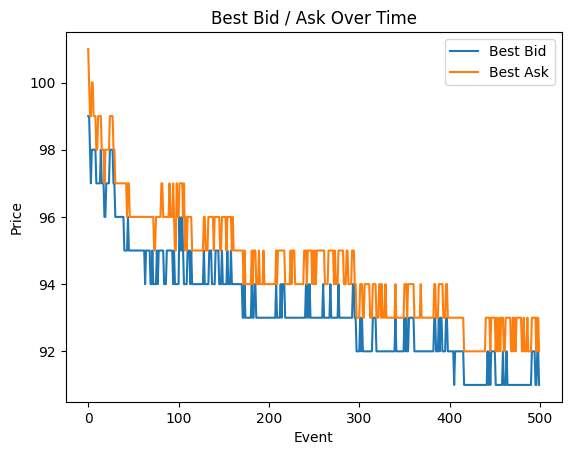

In [60]:
book = OrderBook()
logger = Logger()

agents = (
    [RandomTrader() for _ in range(10)] +
    [MarketMaker()] +
    [MarketTaker()]
)

env = MarketEnvironment(book, agents, logger)

for _ in range(500):
    env.step()

viz = Visualizer()
viz.plot_prices(logger)